## Problem Overview

The goal of this competition is to detect anomalies from multivariate sensor readings collected at regular time intervals from an energy manufacturing plant.

The dataset contains multiple sensor measurements (`X1`–`X5`) along with timestamps.  
The target variable is binary, where:
- `0` → Normal operation
- `1` → Anomalous behavior

The key challenges of this problem are:
- Extreme class imbalance (anomalies are very rare)
- Temporal dependence between observations
- Subtle anomaly patterns that overlap with normal behavior

## Imports

In [ ]:

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score


##  Data Loading

* The training and test datasets are stored in Parquet format.
* Timestamps are converted to datetime format for time-based processing.


In [ ]:
train = pd.read_parquet("/data/train.parquet")
test = pd.read_parquet("/data/test.parquet")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])


## Dataset Overview

Before modeling, we briefly inspect the structure of the provided datasets to understand
the available features and target variable.


### Train Dataset Preview

In [ ]:
train.head()

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


* The training dataset contains multivariate sensor readings collected at regular time intervals, along with a binary target label.
* The target variable indicates whether a given observation corresponds to normal system behavior `0` or an anomalous operating condition `1`.

### Test Dataset Preview

In [ ]:
test.head()


,ID,Date,X1,X2,X3,X4,X5
0,0,2020-12-16,1.685395,5.463917,1.0,7.389056,2.890372
1,1,2020-12-16,1.488844,5.454936,1.0,7.389056,2.890372
2,2,2020-12-16,1.164160,5.471136,1.0,1.000000,2.890372
3,3,2020-12-16,1.000000,5.467385,1.0,1.000000,2.890372
4,4,2020-12-16,1.000000,5.453995,1.0,1.000000,2.833213


* The test dataset contains the same set of sensor readings and temporal features as the training data, but without the target labels.
* The objective is to generate anomaly predictions for these unseen observations based on patterns learned during training.

### Sample Submission Format

In [ ]:
sample_submission = pd.read_parquet("/data/sample_submission.parquet")
sample_submission.head()


,ID,target
0,409856,0
1,409857,0
2,409858,0
3,409859,0
4,409860,0


 The sample submission file defines the required output format for this competition.
 
 Each row consists of a unique identifier `ID` and the corresponding predicted anomaly label `target`, which must be either `0` (normal) or `1` (anomaly).

## Class Imbalance Analysis


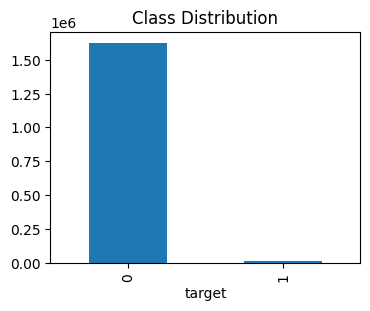

In [ ]:
train["target"].value_counts().plot(kind="bar", figsize=(4,3))
plt.title("Class Distribution")
plt.show()


The dataset exhibits extreme class imbalance, with anomalies accounting for less than 1% of all observations.

This makes anomaly detection particularly challenging and motivates the use of F1-score as the primary evaluation metric instead of accuracy.


## Temporal Visualization of Anomalies


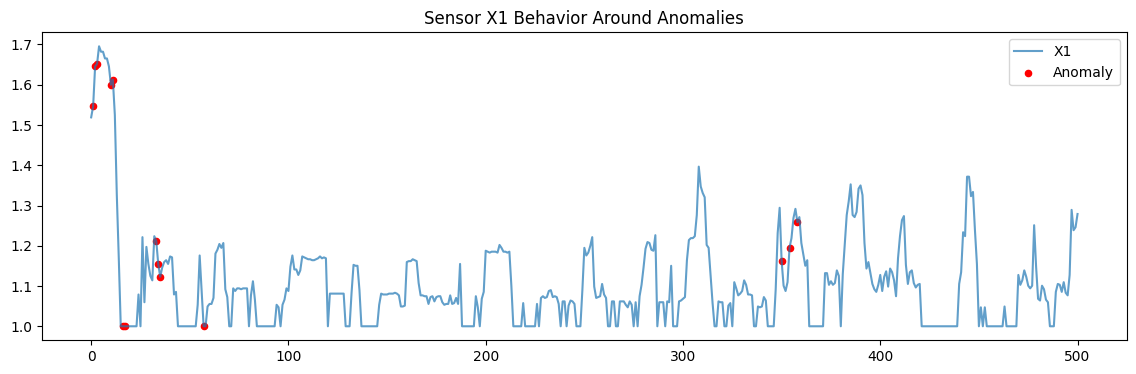

In [ ]:
# Ensure target is integer
train["target"] = train["target"].astype(int)

# Get anomaly indices
anom_idx = np.where(train["target"].values == 1)[0]

# Take first anomaly index
i = int(anom_idx[0])

# Define window
window = 500
start = max(0, i - window)
end = min(len(train), i + window)

subset = train.iloc[start:end]

# Plot X1 with anomalies
plt.figure(figsize=(14, 4))
plt.plot(subset.index, subset["X1"], label="X1", alpha=0.7)
plt.scatter(
    subset.index[subset["target"] == 1],
    subset.loc[subset["target"] == 1, "X1"],
    color="red",
    s=20,
    label="Anomaly"
)
plt.title("Sensor X1 Behavior Around Anomalies")
plt.legend()
plt.show()


Anomalies occur in short bursts and overlap significantly with normal sensor values,
making point-wise anomaly detection inherently challenging.


## Feature Engineering

Given the temporal and multivariate nature of the sensor data, feature engineering
is focused on capturing short-term dynamics, local context, and different operating
regimes of the system.


In [ ]:
train = train.sort_values("Date").reset_index(drop=True)
test = test.sort_values("Date").reset_index(drop=True)

for df in [train, test]:
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df.drop(columns=["Date"], inplace=True)

regime_cols = ["X1", "X2", "X4", "X5"]
kmeans = KMeans(n_clusters=8, random_state=42)

train["regime"] = kmeans.fit_predict(train[regime_cols])
test["regime"] = kmeans.predict(test[regime_cols])

sensor_cols = ["X1", "X2", "X4", "X5"]

for col in sensor_cols:
    for lag in [1, 3, 5, 10]:
        train[f"{col}_lag{lag}"] = train[col].shift(lag)
        test[f"{col}_lag{lag}"] = test[col].shift(lag)

    for win in [5, 10, 20]:
        train[f"{col}_roll_mean_{win}"] = train[col].rolling(win).mean()
        train[f"{col}_roll_std_{win}"] = train[col].rolling(win).std()
        test[f"{col}_roll_mean_{win}"] = test[col].rolling(win).mean()
        test[f"{col}_roll_std_{win}"] = test[col].rolling(win).std()

train.fillna(method="ffill", inplace=True)
test.fillna(method="ffill", inplace=True)


/tmp/ipykernel_17/3844748333.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method="ffill", inplace=True)
/tmp/ipykernel_17/3844748333.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method="ffill", inplace=True)


### Operational Regimes via Clustering

The system operates under different regimes depending on load and operating conditions.
To capture this behavior, KMeans clustering is applied on a subset of sensor readings
(`X1`, `X2`, `X4`, `X5`).

The resulting cluster label is used as a categorical feature representing the current
operational regime of the system.


### Lag Features

Lagged versions of sensor readings (1, 3, 5, and 10 time steps) are created to capture
short-term temporal dependencies.

Since anomalies often occur in brief bursts, recent historical values provide important
context for distinguishing normal fluctuations from anomalous behavior.


### Rolling Window Statistics

Rolling mean and rolling standard deviation features are computed over window sizes
of 5, 10, and 20 time steps.

These features summarize local behavior and help the model detect deviations from
recent trends rather than relying on global thresholds.


### Deviation Features

Additional features are derived by computing the difference and ratio between the
current sensor reading and its rolling mean.

These features explicitly quantify how much the current observation deviates from
its recent baseline, which is particularly useful for detecting subtle anomalies.


### Sensor-Specific Considerations

All sensor signals were initially explored during analysis.

Sensor X3 exhibited very limited temporal variability and behaved almost as a quasi-static
signal. Lag and rolling features derived from X3 did not provide additional discriminative
power and were therefore not expanded extensively.

In contrast, although sensor X4 takes a limited set of discrete values, abrupt transitions
in X4 were observed around anomalous regions. For this reason, lagged and rolling features
were retained for X4 to capture these sudden state changes.


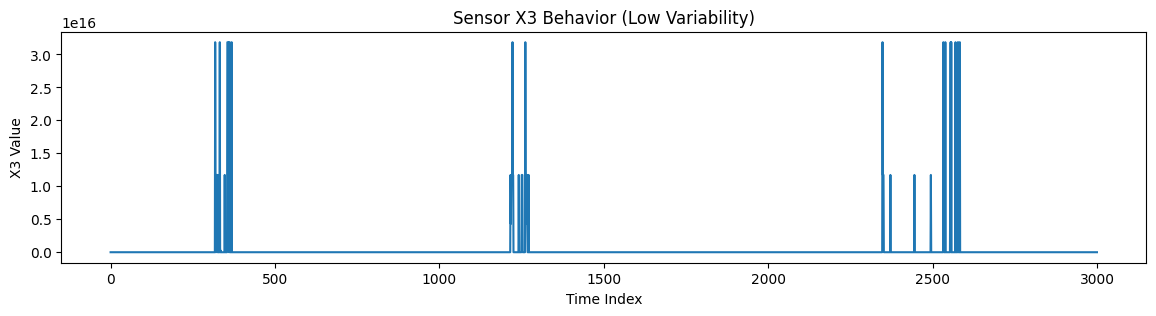

In [ ]:
# Ensure target is integer (only target, not sensors)
train["target"] = train["target"].astype(int)

plt.figure(figsize=(14, 3))
plt.plot(train.index[:3000], train["X3"].iloc[:3000], color="tab:blue")
plt.title("Sensor X3 Behavior (Low Variability)")
plt.xlabel("Time Index")
plt.ylabel("X3 Value")
plt.show()


Sensor X3 shows very limited temporal variation and behaves almost like a
quasi-static signal over time.

Due to this lack of dynamic behavior, lagged and rolling features derived
from X3 were not found to be informative and were therefore not expanded
extensively.


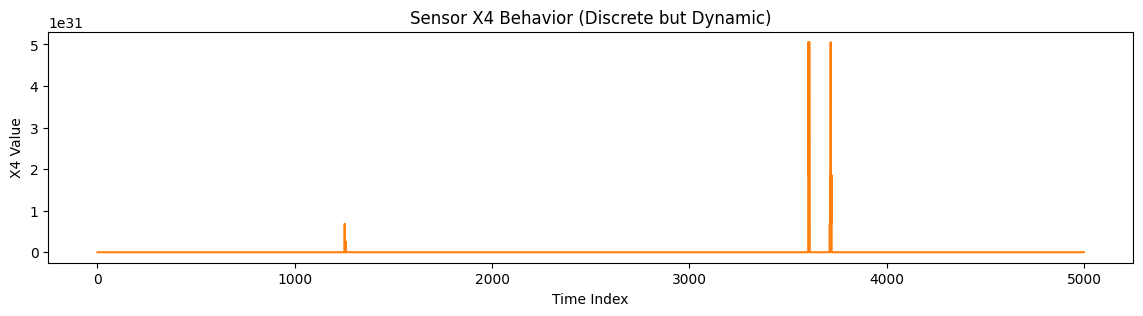

In [ ]:
plt.figure(figsize=(14, 3))
plt.plot(train.index[:5000], train["X4"].iloc[:5000], color="tab:orange")
plt.title("Sensor X4 Behavior (Discrete but Dynamic)")
plt.xlabel("Time Index")
plt.ylabel("X4 Value")
plt.show()


Although sensor X4 takes values from a limited discrete set, it exhibits
abrupt transitions over time.

These sudden state changes were observed to align with anomalous regions,
making lagged and rolling features on X4 useful for anomaly detection.


### Handling Missing Values

Lag and rolling operations introduce missing values at the beginning of the time series.
Forward-fill imputation is applied to preserve causality and prevent information leakage
from future observations.


## Model and Validation Strategy

Given the time-series nature of the data, a random train–test split would lead to
information leakage from future observations.

Therefore, a **time-based cross-validation strategy** is used, where the model is
trained on the earlier portion of the data and validated on the most recent observations.

An 80–20 chronological split is employed to simulate real-world deployment, ensuring
that the model only has access to past data when making predictions.


### Train-Validation Split (Time-Based)

In [ ]:

X = train.drop(columns=["target"])
y = train["target"].astype(int)

test_features = test.drop(columns=["ID"])

# Chronological 80–20 split
n = len(train)
split_idx = int(n * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_valid = X.iloc[split_idx:]
y_valid = y.iloc[split_idx:]

print("Train shape:", X_train.shape)
print("Validation shape:", X_valid.shape)


Train shape: (1311539, 48)
Validation shape: (327885, 48)


LightGBM is selected as the base model due to its strong performance on large tabular
datasets, ability to capture non-linear feature interactions, and computational efficiency.

Class imbalance is handled internally by the model, and threshold tuning is applied
to directly optimize the F1-score.


### Model Training

In [ ]:
cv_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=128,
    max_depth=-1,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,
    random_state=42,
    n_jobs=-1
)

cv_model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 12702, number of negative: 1298837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9339
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009685 -> initscore=-4.627465
[LightGBM] [Info] Start training from score -4.627465


LGBMClassifier(colsample_bytree=0.8, is_unbalance=True, learning_rate=0.02,
               min_data_in_leaf=50, n_estimators=2000, n_jobs=-1,
               num_leaves=128, objective='binary', random_state=42,
               subsample=0.8)

Since the competition metric is F1-score, the classification threshold is tuned on
the validation set instead of using the default value of 0.5.

This allows a better balance between precision and recall under extreme class imbalance.


### Threshold Optimization

In [ ]:

valid_proba = cv_model.predict_proba(X_valid)[:, 1]

thresholds = np.arange(0.75, 0.90, 0.02)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (valid_proba > t).astype(int)
    f1 = f1_score(y_valid, preds)
    print(f"Threshold {t:.2f} -> F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nBest Threshold:", best_threshold)
print("Best Validation F1:", best_f1)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Threshold 0.75 -> F1: 0.6505
Threshold 0.77 -> F1: 0.6498
Threshold 0.79 -> F1: 0.6516
Threshold 0.81 -> F1: 0.6545
Threshold 0.83 -> F1: 0.6575
Threshold 0.85 -> F1: 0.6576
Threshold 0.87 -> F1: 0.6563
Threshold 0.89 -> F1: 0.6566

Best Threshold: 0.8500000000000001
Best Validation F1: 0.6575682382133995


After selecting the optimal threshold, the final model is trained on the full
training dataset using the same hyperparameters.


### Final Model Training

In [ ]:

final_model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=128,
    max_depth=-1,
    min_data_in_leaf=50,
    subsample=0.8,
    colsample_bytree=0.8,
    is_unbalance=True,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 14038, number of negative: 1625386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9338
[LightGBM] [Info] Number of data points in the train set: 1639424, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008563 -> initscore=-4.751733
[LightGBM] [Info] Start training from score -4.751733


LGBMClassifier(colsample_bytree=0.8, is_unbalance=True, learning_rate=0.02,
               min_data_in_leaf=50, n_estimators=2000, n_jobs=-1,
               num_leaves=128, objective='binary', random_state=42,
               subsample=0.8)

## Test Prediction & Submission

In [ ]:

test_proba = final_model.predict_proba(test_features)[:, 1]
predictions = (test_proba > best_threshold).astype(int)

submission = pd.DataFrame({
    "ID": test["ID"],
    "target": predictions
})

submission.to_csv("/output/submission.csv", index=False)
print("submission.csv created successfully")


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
submission.csv created successfully


## Conclusion

This notebook demonstrates a clean, causal approach to anomaly detection in highly imbalanced
time-series data. Due to overlapping patterns between normal and anomalous behavior,
performance is naturally capped for point-wise classification.
